# Analysis of [Spotify reviews](https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022)

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

class colors:
    POSITIVE = '\033[92m'
    NEGATIVE = '\033[91m'
    RESET = '\033[0m'

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

iterations = 2000

spotify_df = pd.read_csv('spotify_reviews.csv')
spotify_df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [39]:
dropped = ['Time_submitted', 'Total_thumbsup', 'Reply']
spotify_df = spotify_df.drop(columns=dropped)
print(f'Dataset size: {spotify_df.shape}')
spotify_df.head()

Dataset size: (61594, 2)


,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1


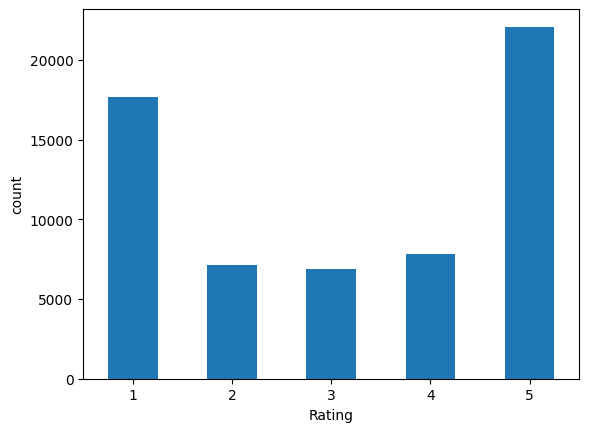

In [40]:
spotify_df.Rating.value_counts().sort_index().plot(kind='bar', rot=0, xlabel='Rating', ylabel='count')
plt.show()

> NOTE: We can see that there are mostly fully positive or fully negative Ratings.

In [41]:
spotify_df['Review'] = spotify_df['Review'].apply(lambda x: remove_punctuation(x) if isinstance(x, str) else '')
spotify_df = spotify_df[spotify_df.Rating != 3]
spotify_df.loc[spotify_df["Rating"] <= 2, "Rating"] = -1
spotify_df.loc[spotify_df["Rating"] >= 4, "Rating"] = 1

> NOTE: Next up I classified the data:
> 1) I dropped all the rows in which the Rating was 3 (so the reviews were having neutral sentiment [there were 5 possible Ratings: 1,2,3,4,5])
> 2) Next up I've changed all positive reviews ($\geq$ 4) to 1 and negative ($\leq$ 2) to -1 

In [42]:
smaller_df = spotify_df[:20000]
X_train, X_test, y_train, y_test = train_test_split(smaller_df['Review'], smaller_df['Rating'], test_size=0.3, random_state=44)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

> NOTE: I made the vectorization using the training dataset (0.3 of the original dataset) and received a vector of size (38295, 22530).

In [43]:
model = LogisticRegression(max_iter=iterations)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [44]:
coefs = model.coef_.reshape(-1, 1)
new_coefs = np.array([coef[0] for coef in coefs])

most_positive_idx = (-new_coefs).argsort()[:10]
most_negative_idx = new_coefs.argsort()[:10]

most_positive = [vectorizer.get_feature_names_out()[i] for i in most_positive_idx]
most_negative = [vectorizer.get_feature_names_out()[i] for i in most_negative_idx]

print('Most positive words:', *most_positive)
print('Most negative words:', *most_negative)

Most positive words: best excellent awesome love amazing easy great wonderful nice live
Most negative words: worst horrible tired logo trash terrible awful infuriating useless glitchy


> NOTE: We can see that the positive and the negative words fit nicely in their category

In [45]:
y_pred_prob = model.predict_proba(X_test)

negative = y_pred_prob[:, 0]
positive = y_pred_prob[:, 1]

most_negative_idx = (-negative).argsort()[:5]
most_positive_idx = positive.argsort()[-5:]

print('Most negative reviews row numbers:', *most_negative_idx)
print('Most positive reviews row numbers:', *most_positive_idx)

print(f'{colors.NEGATIVE}red {colors.RESET} means a negative review (value == -1)')
print(f'{colors.POSITIVE}green {colors.RESET} means a positive review (value == 1)')

_ = 'Most positive reviews according to probability:'
print(f"\n{_}")

for idx in most_positive_idx:
    color = colors.POSITIVE if np.array(smaller_df['Rating'])[idx] == 1 else colors.NEGATIVE
    print(f'\t{color}{idx}:{colors.RESET}', np.array(smaller_df['Review'])[idx])

_ = _.replace('positive', 'negative')
print(f"\n{_}")

for idx in most_negative_idx:
    color = colors.POSITIVE if np.array(smaller_df['Rating'])[idx] == 1 else colors.NEGATIVE
    print(f'\t{color}{idx}:{colors.RESET}',np.array(smaller_df['Review'])[idx])

print(f'\nModel score: {model.score(X_test, y_test)}')


Most negative reviews row numbers: 130 4456 2143 1153 577
Most positive reviews row numbers: 305 816 2094 5844 3621
red  means a negative review (value == -1)
green  means a positive review (value == 1)

Most positive reviews according to probability:
	305: The app is so glitchy on Android that it wont let me play any music on my phone Its been this way for 2 months now and at the worst time while I was on a road trip and needed tunes And no customer support number to help me fix itWhat am I paying for exactly Going to try to get refunded maybe Ill sign up again if they fix the app
	816: Awful app and service No longer paying for premium as spotify simply does not work
	2094: ITS AMAZING I love how i can do whatever I want with my music I am speechless ❤️❤️❤️
	5844: The best application to listen to music
	3621: It is the best app for streaming music 🎶

Most negative reviews according to probability:
	130: I have used this app for a few years now Love it so much
	4456: A ton of content

> NOTE: The model Rating was 0.876 which is a quite high of a score - meaning that the data was correcly split.

In [46]:
significant_words = [*most_positive, *most_negative]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(smaller_df['Review'], smaller_df['Rating'], test_size=0.3, random_state=44)
vectorizer = CountVectorizer(vocabulary=significant_words)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
model = LogisticRegression(max_iter=iterations)
model.fit(X_train, y_train)

coefs = model.coef_.reshape(-1, 1)
new_coefs = np.array([coef[0] for coef in coefs])

most_positive_idx = (-new_coefs).argsort()[:10]
most_negative_idx = new_coefs.argsort()[:10]

most_positive = [vectorizer.get_feature_names_out()[i] for i in most_positive_idx]
most_negative = [vectorizer.get_feature_names_out()[i] for i in most_negative_idx]

print('Most positive words:', *most_positive)
print('Most negative words:', *most_negative, end='\n\n')
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
negative = y_pred_prob[:, 0]
positive = y_pred_prob[:, 1]

most_negative_idx = (-negative).argsort()[:5]
most_positive_idx = positive.argsort()[-5:]
print('Most positive reviews row numbers:', *most_positive_idx)
print('Most negative reviews row numbers:', *most_negative_idx, end='\n\n')

print(f'{colors.NEGATIVE}red {colors.RESET} means a negative review (value == -1)')
print(f'{colors.POSITIVE}green {colors.RESET} means a positive review (value == 1)')

_ = '\nMost positive reviews according to probability:'
print(_)
for idx in most_positive_idx:
    color = colors.POSITIVE if np.array(smaller_df['Rating'])[idx] == 1 else colors.NEGATIVE
    print(f'\t{color}{idx}:{colors.RESET}', np.array(smaller_df['Review'])[idx])

_ = _.replace('positive', 'negative')
print(_)
for idx in most_negative_idx:
    color = colors.POSITIVE if np.array(smaller_df['Rating'])[idx] == 1 else colors.NEGATIVE
    print(f'\t{color}{idx}:{colors.RESET}',np.array(smaller_df['Review'])[idx])

print(f'\nModel score: {model.score(X_test, y_test)}')

Most positive words: best excellent awesome wonderful amazing nice love easy great live
Most negative words: worst trash logo terrible awful useless tired glitchy infuriating horrible

Most positive reviews row numbers: 816 5650 3036 4199 3621
Most negative reviews row numbers: 149 2898 3139 5881 3126

red  means a negative review (value == -1)
green  means a positive review (value == 1)

Most positive reviews according to probability:
	816: Awful app and service No longer paying for premium as spotify simply does not work
	5650: Its so hard to just get one song on And 6 skips per hour No This update has made it so hard to function anything I would rate it lower if it was even possible
	3036: There so much ads after every single songs
	4199: Cant play on s22 without it pausing when screen is locked Changed permissions and reinstalled and hasnt changed
	3621: It is the best app for streaming music 🎶

Most negative reviews according to probability:
	149: Easy to opporate and the pmaylist

> NOTE: Using the limited dictionary we achieved worse results - the model Rating is now 0.72
>
> The positive reviews were mostly predicted uncorrect (4/5).
> The negative reviews were mostly predicted uncorrect (3/5).
>
> The most positive/negative predictions may be bad because we took a bad vocabulary (or to short of a vocabulary). 
> If we want to increate the Rating of the predictions we should think about adding more words to vocabulary.

In [48]:
coefs = np.array([coef for coef in model.coef_[0]])
idx = coefs.argsort()
for i in idx:
    color = colors.POSITIVE if coefs[i] > 0 else colors.NEGATIVE
    print(f'{color}{round(coefs[i],5):>8}{colors.RESET}: {vectorizer.get_feature_names_out()[i]}')

-3.03841: worst
-2.75618: trash
-2.68209: logo
-2.68013: terrible
-2.66902: awful
-2.37019: useless
-2.35925: tired
-2.17297: glitchy
-2.12849: infuriating
-2.12398: horrible
 1.41897: live
 1.70268: great
 2.11377: easy
 2.14081: love
 2.17415: nice
 2.21666: amazing
 2.34981: wonderful
 2.55462: awesome
 2.75647: excellent
 3.17693: best


> NOTE: We can see that the most negative words were: worst, trash, terrible - all having negative meaning in english
> 
> When it comes to positive words they were: best, excellent, awesome - all of them having a very positive meaning in english
> 
> So the model got the positive and negative words impacts right.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(smaller_df['Review'], smaller_df['Rating'], test_size=0.3, random_state=44)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
model = LogisticRegression(max_iter=iterations)
print('Timing fit of model without limited dictionary...')
%timeit model.fit(X_train, y_train)
print(f'Model Rating: {model.score(X_test, y_test)}', end='\n\n')

X_train, X_test, y_train, y_test = train_test_split(smaller_df['Review'], smaller_df['Rating'], test_size=0.3, random_state=44)
vectorizer = CountVectorizer(vocabulary=significant_words)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
model = LogisticRegression(max_iter=iterations)
print('Timing fit of model with limited dictionary...')
%timeit model.fit(X_train, y_train)
print(f'Model Rating: {model.score(X_test, y_test)}')

Timing fit of model without limited dictionary...
1.61 s ± 26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Model Rating: 0.8768333333333334

Timing fit of model with limited dictionary...
43.2 ms ± 3.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Model Rating: 0.7205


> NOTE: The time difference the model in which we used predefined vocabulary is enormous (almost 40x) - because we do not have to analyze all of the words but only ones from the given vocabulary.  
> Of course because of that the score is worse (but we discussed it before, as it is the same model as previously)

# Note: We now begin comparing different classifiers

In [50]:
# HELPER FUNCTIONS
    
def get_model(vectorizer, model, vectorizer_name, model_name):
    X_train, X_test, y_train, y_test = train_test_split(smaller_df['Review'], smaller_df['Rating'], test_size=0.3, random_state=44)

    ctmTr = vectorizer.fit_transform(X_train)
    X_test_dtm = vectorizer.transform(X_test)

    print(f'Timing fit of {model_name}...')
    %timeit model.fit(ctmTr, y_train)

    model_score = model.score(X_test_dtm, y_test)
    print(f"Results for {model_name} with {vectorizer_name}")
    print(f'Model score: {model_score}')

    y_pred_lr = model.predict(X_test_dtm)

    cm_lr = confusion_matrix(y_test, y_pred_lr)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()

    print(f'True negative: {tn}')
    print(f'False positive: {fp}')
    print(f'False negative: {fn}')
    print(f'True positive: {tp}')

    tpr_lr = round(tp/(tp+fn), 4)
    tnr_lr = round(tn/(tn+fp), 4)
    print(f'True positive rate: {tpr_lr}\nTrue negative rate: {tnr_lr}')


In [51]:
get_model(CountVectorizer(), LogisticRegression(max_iter=iterations), 'CountVectorizer', 'Logistic Regression')

Timing fit of Logistic Regression...
1.63 s ± 51.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Results for Logistic Regression with CountVectorizer
Model score: 0.8768333333333334
True negative: 2029
False positive: 402
False negative: 337
True positive: 3232
True positive rate: 0.9056
True negative rate: 0.8346


> NOTE: Logistic Regression with CountVectorizer achieved: 
>
> * score of 0.876
> * true positive rate of 0.905
> * true negative rate of 0.834
> * it took about 1.6s 
>
> It achieved overall quite high of a score, but maybe we can do better with different models

In [52]:
get_model(CountVectorizer(), svm.SVC(), 'CountVectorizer', 'Support Vector Machine')

Timing fit of Support Vector Machine...
30 s ± 877 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Results for Support Vector Machine with CountVectorizer
Model score: 0.8736666666666667
True negative: 2101
False positive: 330
False negative: 428
True positive: 3141
True positive rate: 0.8801
True negative rate: 0.8643


> NOTE: Support Vector Machine with CountVectorizer achieved: 
> * score of 0.873 (**worse** than Logistic Regression) 
> * true positive rate of 0.88 (**worse** than Logistic Regression)
> * true negative rate of 0.864 (**better** than Logistic Regression)
> * it took about 30s (almost 20x **longer** than Logistic Regression)
>
> Comparing it with Logistic Regression it achieved worse overall score in longer time.

In [57]:
get_model(CountVectorizer(), KNeighborsClassifier(n_neighbors=5), 'CountVectorizer', 'K Neighbors Classifier')

Timing fit of K Neighbors Classifier...
2.38 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Results for K Neighbors Classifier with CountVectorizer
Model score: 0.712
True negative: 927
False positive: 1504
False negative: 224
True positive: 3345
True positive rate: 0.9372
True negative rate: 0.3813


> Note: K Neighbors Classifier with CountVectorizer achieved:
> * score of 0.712 (**worse** than the previous two) 
> * true positive rate of 0.937 (**better** than the previous two)
> * true negative rate of 0.381 (**worse** than the previous two)
> * it took about 2.38ms (almost 800x **faster** than Logistic Regression)
>
> Comparing it with the previous two it achieved worse overall score but with much less time taken. \
Depending on what we want to achieve it might be a good choice. Of course we could improve the Rating score the number of neighbours. 
>
> **Best overall Rating was achieved by Logistic Regression with CountVectorizer**

# Using TF-IDF instead of CountVectorizer

In [54]:
get_model(TfidfVectorizer(), LogisticRegression(), 'TF-IDF', 'Logistic Regression')

Timing fit of Logistic Regression...
390 ms ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Results for Logistic Regression with TF-IDF
Model score: 0.883
True negative: 2083
False positive: 348
False negative: 354
True positive: 3215
True positive rate: 0.9008
True negative rate: 0.8568


In [55]:
get_model(TfidfVectorizer(), svm.SVC(kernel='rbf'), 'TF-IDF', 'Support Vector Machine')

Timing fit of Support Vector Machine...
57.5 s ± 1.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Results for Support Vector Machine with TF-IDF
Model score: 0.8886666666666667
True negative: 2133
False positive: 298
False negative: 370
True positive: 3199
True positive rate: 0.8963
True negative rate: 0.8774


In [56]:
get_model(TfidfVectorizer(), KNeighborsClassifier(n_neighbors=5), 'TF-IDF', 'K Neighbors Classifier')

Timing fit of K Neighbors Classifier...
2.91 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Results for K Neighbors Classifier with TF-IDF
Model score: 0.809
True negative: 1634
False positive: 797
False negative: 349
True positive: 3220
True positive rate: 0.9022
True negative rate: 0.6722


> NOTE: After checking the same classifiers with TF-IDF we achieved interesting results.  
> The best overall Rating with TF-IDF was achieved by SVM:
> * Rating of 0.888 (**better** than Logistic Regression with CountVectorizer)
> * true positive rate of 0.896 (**worse** than Logistic Regression with CountVectorizer)
> * true negative rate of 0.877 (**better** than Logistic Regression with CountVectorizer)